In [61]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sktime.forecasting.all import temporal_train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_absolute_scaled_error
from scipy import stats
from scipy.special import inv_boxcox
import statsmodels.api as sm

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
msft = pd.read_csv("msft.csv",index_col=0)
train_msft = pd.read_csv("train_msft.csv",index_col=0)
test_msft = pd.read_csv("test_msft.csv",index_col=0)
val_msft = pd.read_csv("val_msft.csv",index_col=0)

# EDA

In [6]:
msft

,adj_close
date,
2000-01-03,36.263777
2000-01-04,35.037977
2000-01-05,35.408206
2000-01-06,34.222851
2000-01-07,34.670859
...,...
2023-12-22,373.895194
2023-12-26,373.975047
2023-12-27,373.386126


In [3]:
msft.describe()

,adj_close
count,6037.000000
mean,72.005855
std,90.181050
min,11.323847
25%,19.070101
50%,23.766328
75%,80.339023
max,382.000349


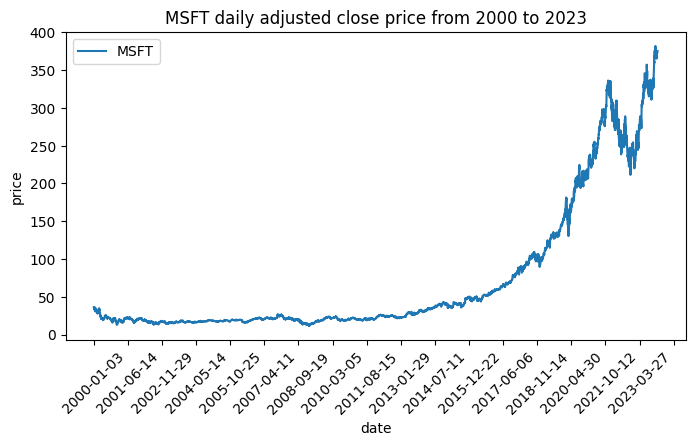

In [7]:
plt.figure(figsize=(8,4))
plt.plot(msft['adj_close'],label='MSFT')
plt.title('MSFT daily adjusted close price from 2000 to 2023')
plt.xlabel('date')
plt.ylabel('price')
# Set the locator
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
plt.gca().xaxis.set_major_locator(locator)
# Rotate dates for better readability
plt.xticks(rotation=45)
plt.legend()
plt.show()

# identify seasonal/non-seasonal difference of the training set

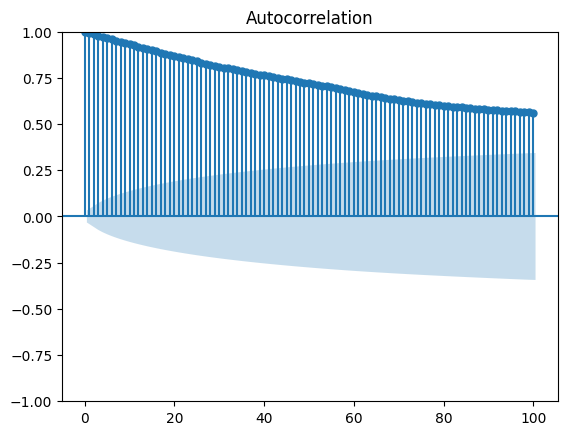

In [33]:
plot_acf(train_msft,lags=100);

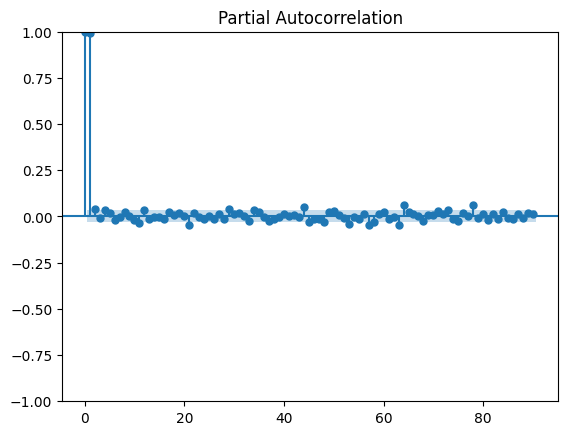

In [34]:
plot_pacf(train_msft['adj_close'],lags=90);

In [14]:
# ADF test
def adf_test(ts):
    display("Results of ADF Test:")
    dftest = adfuller(ts, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    display(dfoutput)

# KPSS test
def kpss_test(ts):
    display("Results of KPSS Test:")
    kpsstest = kpss(ts, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    display(kpss_output)

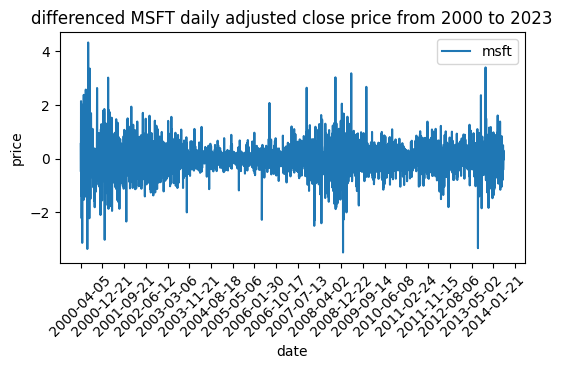

In [29]:
train_msft_sdiff = train_msft['adj_close'].diff(64).dropna() #quarterly lag 64
train_msft_sdiff_diff = train_msft_sdiff.diff(1).dropna()
plt.figure(figsize=(6,3))
plt.plot(train_msft_sdiff_diff,label='msft')
plt.title('differenced MSFT daily adjusted close price from 2000 to 2023')
plt.xlabel('date')
plt.ylabel('price')
# Set the locator
locator = mdates.AutoDateLocator(minticks=15, maxticks=20)
plt.gca().xaxis.set_major_locator(locator)
# Rotate dates for better readability
plt.xticks(rotation=45)
plt.legend()
plt.show()


what incidents may account for the larger volatility during 2000/2008/2012 for microsoft?

In [27]:
adf_test(train_msft_sdiff_diff)

'Results of ADF Test:'

Test Statistic                  -28.440997
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    3552.000000
Critical Value (1%)              -3.432192
Critical Value (5%)              -2.862354
Critical Value (10%)             -2.567203
dtype: float64

In [28]:
kpss_test(train_msft_sdiff_diff)

'Results of KPSS Test:'

Test Statistic            0.026353
p-value                   0.100000
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

- For ADF test, the test statistics is bigger than the critical value at 1%. Thus, null hypothesis is rejected at 1% significant level, and the time series is stationary.  
- For KPSS test, the test statistics is smaller than the critical value at 1%. Therefore, we can't reject the null hypothesis, and the time series is stationary.  
- From the plot, we can roughly say that the time series data is stationary.

To conclude, after taking the lag 1 difference, the msft daily adjusted close data is transformed into a stationary time series data.

# SARIMA model

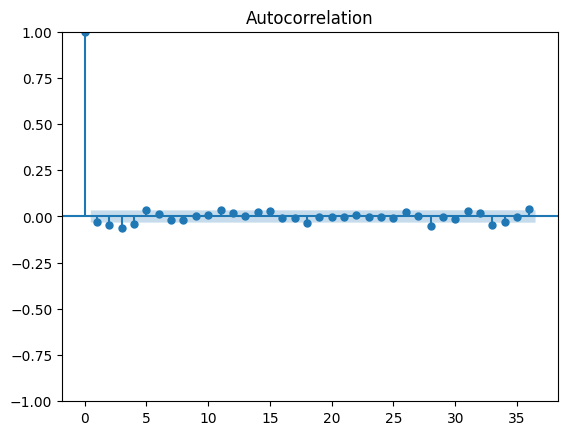

In [38]:
plot_acf(train_msft_sdiff_diff);

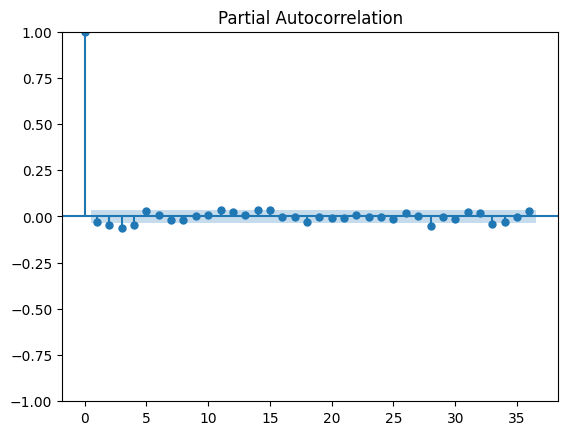

In [37]:
plot_pacf(train_msft_sdiff_diff);

seems no AR and MA part...

In [31]:
# fit the model
sarima_model = sm.tsa.statespace.SARIMAX(endog=train_msft,order=(1,1,1), seasonal_order=(0, 1, 0, 64)).fit(method='cg')
display(sarima_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           adj_close   No. Observations:                 3622
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 64)   Log Likelihood              -11181.812
Date:                             Thu, 02 May 2024   AIC                          22369.624
Time:                                     22:41:18   BIC                          22388.155
Sample:                                          0   HQIC                         22376.232
                                            - 3622                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000      0.012    -86.791      0.000      -1.023      -0.977
ma.L1         -1.0000      0.150     -6.684      0.000      -1.293      -0.707
sigma2        41.5774      6.128      6.784      0.000      29.566      53.589
===================================================================================
Ljung-Box (L1) (Q):                3472.05   Jarque-Bera (JB):                30.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
sarima_model2 = sm.tsa.statespace.SARIMAX(endog=train_msft,order=(0,1,0), seasonal_order=(0, 1, 0, 64)).fit(method='cg')
display(sarima_model2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          adj_close   No. Observations:                 3622
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 64)   Log Likelihood               -4756.428
Date:                            Thu, 02 May 2024   AIC                           9514.855
Time:                                    23:19:27   BIC                           9521.032
Sample:                                         0   HQIC                          9517.058
                                           - 3622                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1042      0.000    261.371      0.000       0.103       0.105
===================================================================================
Ljung-Box (L1) (Q):                   2.82   Jarque-Bera (JB):              4564.12
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
sarima_model3 = sm.tsa.statespace.SARIMAX(endog=train_msft,order=(1,1,0), seasonal_order=(0, 1, 0, 64)).fit(method='cg')
display(sarima_model3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          adj_close   No. Observations:                 3622
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 64)   Log Likelihood               -4775.437
Date:                            Thu, 02 May 2024   AIC                           9554.875
Time:                                    23:20:14   BIC                           9567.228
Sample:                                         0   HQIC                          9559.280
                                           - 3622                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0281      0.004      7.325      0.000       0.021       0.036
sigma2         0.1040      0.000    261.083      0.000       0.103       0.105
===================================================================================
Ljung-Box (L1) (Q):                  10.72   Jarque-Bera (JB):              4558.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
sarima_model4 = sm.tsa.statespace.SARIMAX(endog=train_msft,order=(0,1,1), seasonal_order=(0, 1, 0, 64)).fit(method='cg')
display(sarima_model4.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           adj_close   No. Observations:                 3622
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 64)   Log Likelihood               -4758.116
Date:                             Thu, 02 May 2024   AIC                           9520.232
Time:                                     23:25:22   BIC                           9532.585
Sample:                                          0   HQIC                          9524.637
                                            - 3622                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0312      0.004     -8.057      0.000      -0.039      -0.024
sigma2         0.1040      0.000    261.485      0.000       0.103       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4556.19
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

by AIC metric, the best model is SARIMA(0,1,0)(0,1,0,64), no AR/MA component

# Residual analysis

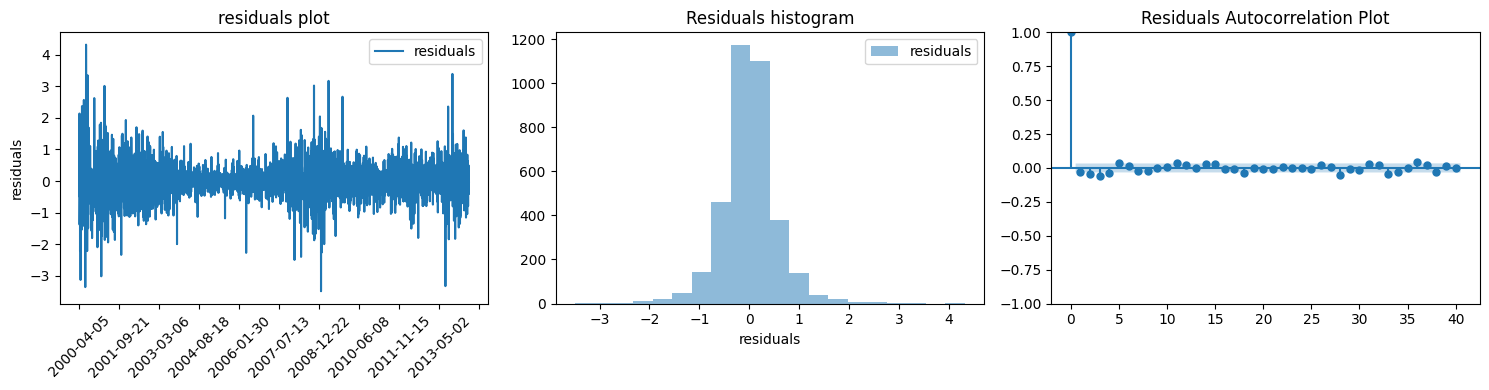

In [48]:
residuals = pd.DataFrame(sarima_model2.resid, columns=['residuals'])

def resid_plot(resid):
    locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
    fig, axs = plt.subplots(1,3, figsize=(15, 4))  # 2 rows, 2 column

    # Residuals plot
    axs[0].plot(resid, label='residuals')
    axs[0].set_title('residuals plot')
    axs[0].xaxis.set_major_locator(locator)
    axs[0].tick_params(axis='x', rotation=45)
    axs[0].set_ylabel('residuals')
    axs[0].legend()

    # Residuals histogram
    axs[1].hist(resid, alpha=0.5, bins=20, label='residuals')
    axs[1].set_title('Residuals histogram')
    axs[1].set_xlabel('residuals')
    axs[1].legend()

    # Residuals ACF plot
    plot_acf(resid, lags=40, ax=axs[2], title='Residuals Autocorrelation Plot')

    plt.tight_layout()
    plt.show()

resid_plot(residuals[65:])

In [49]:
sm.stats.acorr_ljungbox(residuals, lags=[12], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
12,23.457633,0.024083,23.408025,0.024455


residuals seem not to act  like a white noise

# predicting with the validation set

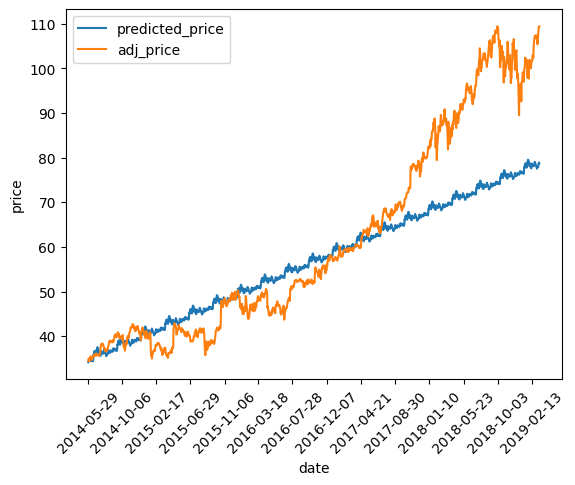

In [60]:
val_pred=sarima_model2.forecast(steps = len(val_msft)).to_frame()
val_pred.index = val_msft.index
plt.plot(val_pred['predicted_mean'], label='predicted_price')
plt.plot(val_msft['adj_close'], label='adj_price')
plt.xlabel('date')
plt.ylabel('price')
# Set the locator
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
plt.gca().xaxis.set_major_locator(locator)
# Rotate dates for better readability
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [63]:
def evaluation(test, predict, train, model_name):
    mae = mean_absolute_error(test, predict)
    mse = mean_squared_error(test, predict)
    mape = mean_absolute_percentage_error(test, predict)
    smape = mean_absolute_percentage_error(test, predict, symmetric=True)
    mase = mean_absolute_scaled_error(test, predict, y_train=train)
    evaluation_metrics = pd.DataFrame([mae, mse, mape, smape, mase],columns=[model_name], index=['mae','mse','mape','smape','mase'])
    return evaluation_metrics

In [64]:
sarima_eval = evaluation(val_msft,val_pred,train_msft,'ARIMA')
display(sarima_eval)

,ARIMA
mae,8.495576
mse,156.721090
mape,0.115027
smape,0.121386
mase,31.054990
